# Route Optimization for Rubbish Collection using Genetic Algorithm

### IMPORTING LIBRARIES

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import random
from deap import base, creator, tools, algorithms
import itertools
import numpy as np

## Step 1: Data Preprocessing

In [15]:


# Load dataset
file_path = 'Route_Optimization_Data.csv'
route_data_df = pd.read_csv(file_path)

# Drop any missing values if necessary
route_data_df.dropna(inplace=True)

# Add computed columns for more accessible interpretation
route_data_df['Total_Fuel_Consumed'] = (route_data_df['Fuel_Consumption_L_per_100km'] * route_data_df['Route_Length_km']) / 100
route_data_df['Total_Travel_Time'] = route_data_df['Travel_Time_min']

# Aggregating by Route_ID to get overall fuel and time per route
aggregated_data = route_data_df.groupby("Route_ID").agg({
    "Total_Fuel_Consumed": "sum",
    "Total_Travel_Time": "sum"
}).reset_index()
    

#### 1.1  Data Exploration

In [16]:
route_data_df.head(10)

,Route_ID,Day,Stop_Number,Route_Length_km,Traffic_Condition,Average_Speed_km_h,Fuel_Consumption_L_per_100km,Travel_Time_min,Stop_Time_Spent_min,Waste_Collected_kg,Total_Fuel_Consumed,Total_Travel_Time
0,1,1,1,25.52,High,24.44,7.73,62.65,11.66,38.76,1.972696,62.65
1,1,1,2,25.52,High,24.44,7.73,62.65,10.91,54.58,1.972696,62.65
2,1,1,3,25.52,High,24.44,7.73,62.65,8.83,33.16,1.972696,62.65
3,1,1,4,25.52,High,24.44,7.73,62.65,14.72,54.68,1.972696,62.65
4,1,1,5,25.52,High,24.44,7.73,62.65,7.36,57.36,1.972696,62.65
5,1,1,6,25.52,High,24.44,7.73,62.65,7.56,48.49,1.972696,62.65
6,1,1,7,25.52,High,24.44,7.73,62.65,7.02,40.34,1.972696,62.65
7,1,1,8,25.52,High,24.44,7.73,62.65,13.96,76.34,1.972696,62.65
8,1,1,9,25.52,High,24.44,7.73,62.65,11.96,39.75,1.972696,62.65
9,1,1,10,25.52,High,24.44,7.73,62.65,6.39,58.73,1.972696,62.65


In [17]:
route_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44730 entries, 0 to 44729
Data columns (total 12 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Route_ID                      44730 non-null  int64  
 1   Day                           44730 non-null  int64  
 2   Stop_Number                   44730 non-null  int64  
 3   Route_Length_km               44730 non-null  float64
 4   Traffic_Condition             44730 non-null  object 
 5   Average_Speed_km_h            44730 non-null  float64
 6   Fuel_Consumption_L_per_100km  44730 non-null  float64
 7   Travel_Time_min               44730 non-null  float64
 8   Stop_Time_Spent_min           44730 non-null  float64
 9   Waste_Collected_kg            44730 non-null  float64
 10  Total_Fuel_Consumed           44730 non-null  float64
 11  Total_Travel_Time             44730 non-null  float64
dtypes: float64(8), int64(3), object(1)
memory usage: 4.1+ MB


## Step 2: Data Visualization

In [18]:
def visualize_data(data, x=None, y=None, kind="hist", bins=20, kde=True, title="", xlabel="", ylabel=""):
    plt.figure(figsize=(10, 6))
    
    if kind == "hist":
        sns.histplot(data[x], bins=bins, kde=kde)
    elif kind == "scatter":
        sns.scatterplot(data=data, x=x, y=y)
    else:
        raise ValueError("Unsupported plot type. Use 'hist' or 'scatter'.")
    
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()



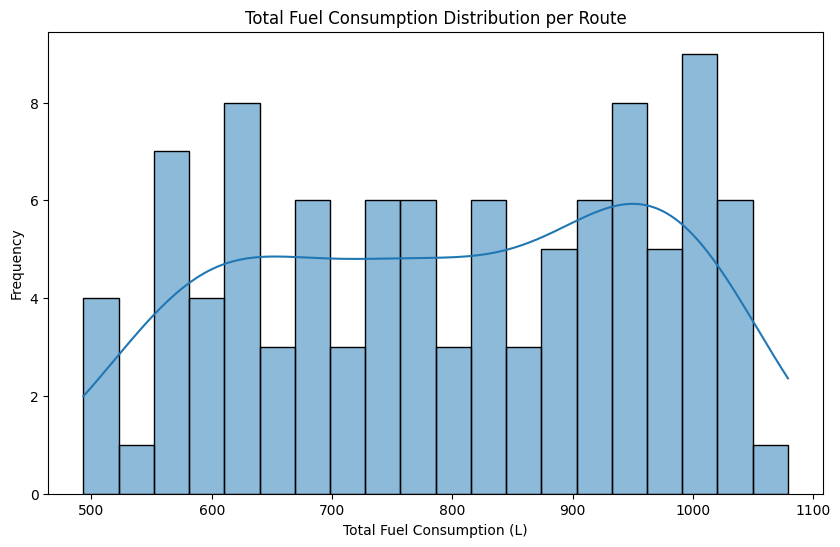

In [19]:
# Instantiate visualizations
visualize_data(
    data=aggregated_data,
    x="Total_Fuel_Consumed",
    kind="hist",
    bins=20,
    kde=True,
    title="Total Fuel Consumption Distribution per Route",
    xlabel="Total Fuel Consumption (L)",
    ylabel="Frequency"
)



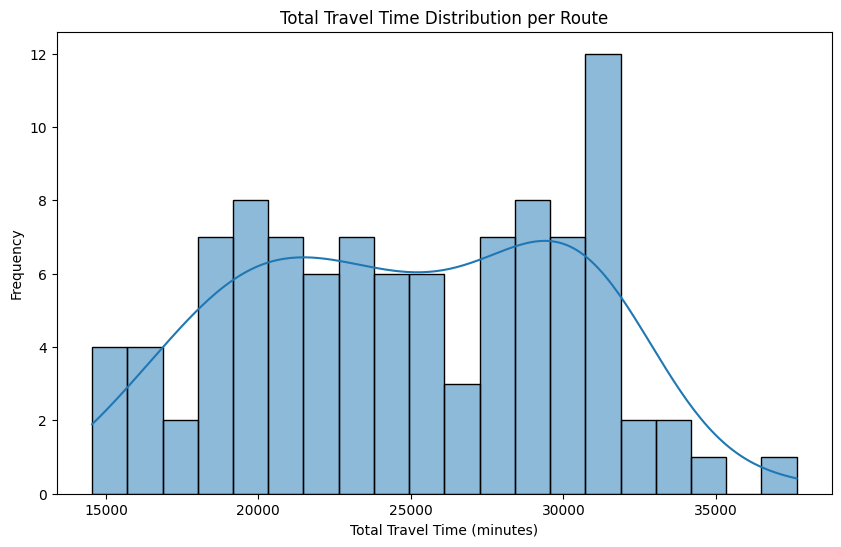

In [20]:
visualize_data(
    data=aggregated_data,
    x="Total_Travel_Time",
    kind="hist",
    bins=20,
    kde=True,
    title="Total Travel Time Distribution per Route",
    xlabel="Total Travel Time (minutes)",
    ylabel="Frequency"
)



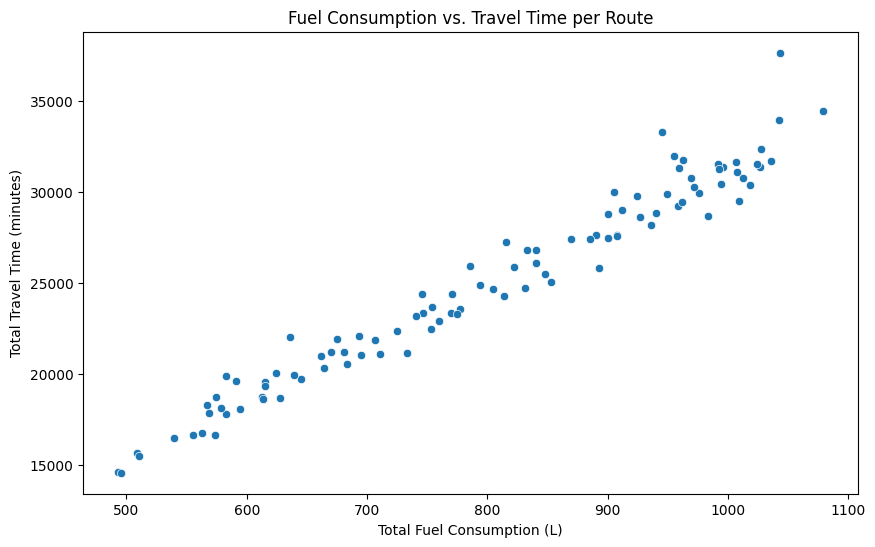

In [21]:
visualize_data(
    data=aggregated_data,
    x="Total_Fuel_Consumed",
    y="Total_Travel_Time",
    kind="scatter",
    title="Fuel Consumption vs. Travel Time per Route",
    xlabel="Total Fuel Consumption (L)",
    ylabel="Total Travel Time (minutes)"
)


## Step 3: Data Presentation

In [22]:
# Display summary statistics of the aggregated data
print("Aggregated Route Data Summary:")
print(aggregated_data.describe())

Aggregated Route Data Summary:
         Route_ID  Total_Fuel_Consumed  Total_Travel_Time
count  100.000000           100.000000         100.000000
mean    50.500000           798.798201       24905.710900
std     29.011492           164.156388        5360.136158
min      1.000000           493.307200       14548.800000
25%     25.750000           657.314339       20466.210000
50%     50.500000           809.423495       24781.420000
75%     75.250000           950.644645       29563.942500
max    100.000000          1078.949979       37652.400000


### Correlation Matrix

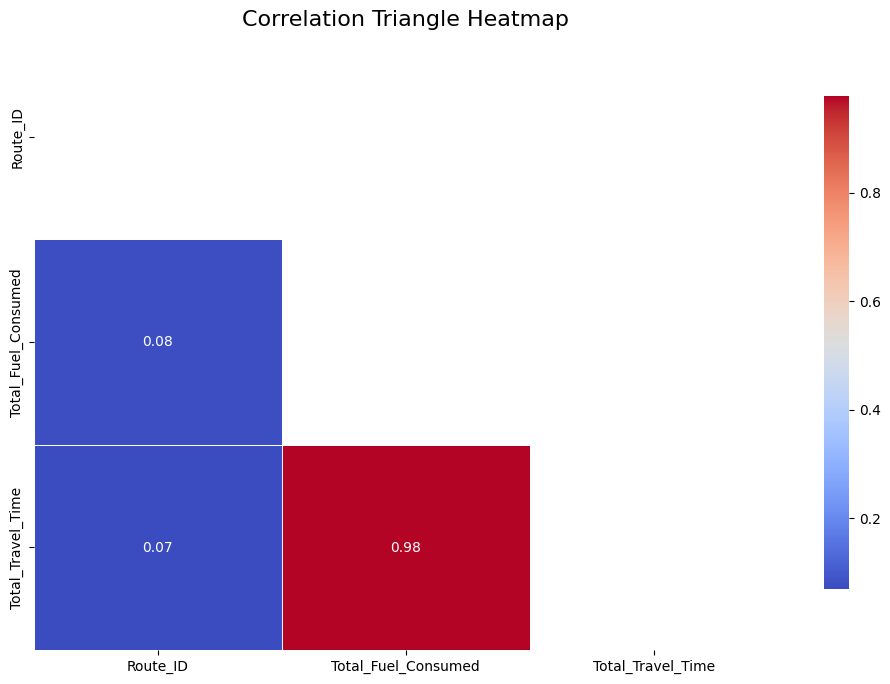

In [23]:
# Calculate the correlation matrix
correlation_matrix = aggregated_data.corr()

# Create a mask to display only the lower triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Set up the figure dimensions
plt.figure(figsize=(12, 8))

# Draw the heatmap
sns.heatmap(
    correlation_matrix,
    mask=mask,
    cmap='coolwarm',
    annot=True,
    fmt=".2f",
    linewidths=0.5,
    cbar_kws={"shrink": 0.8},
)

# Add a title
plt.title("Correlation Triangle Heatmap", fontsize=16)
plt.show()


## Step 4: Data Modeling with Grid Search (No Data Standardization)

In [24]:
import time
# Create fitness and individual types
creator.create("FitnessMin", base.Fitness, weights=(-1.0, -1.0))  # Minimize both fuel and time
creator.create("Individual", list, fitness=creator.FitnessMin)

# Initialize the DEAP toolbox
toolbox = base.Toolbox()

# Define the individual as a random sequence of Route_IDs
route_ids = aggregated_data["Route_ID"].tolist()
toolbox.register("indices", random.sample, route_ids, len(route_ids))
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.indices)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Fitness function to evaluate travel time and fuel consumption
def evaluate(individual):
    total_fuel = sum(aggregated_data[aggregated_data["Route_ID"] == route]["Total_Fuel_Consumed"].values[0] for route in individual)
    total_time = sum(aggregated_data[aggregated_data["Route_ID"] == route]["Total_Travel_Time"].values[0] for route in individual)
    return total_fuel, total_time  # Return both objectives

toolbox.register("evaluate", evaluate)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.05)
toolbox.register("select", tools.selNSGA2)  # Use NSGA-II for multi-objective optimization
# Modified genetic algorithm to track convergence, Pareto front, and other metrics
def run_ga_with_params(pop_size, cxpb, mutpb, n_generations):
    pop = toolbox.population(n=pop_size)
    hof = tools.HallOfFame(1)
    
    # Track metrics
    fitness_values = []  # For convergence plot
    populations = []  # For Pareto front analysis
    diversity_metrics = []  # For diversity analysis
    best_solutions = []  # For hyperparameter stability
    start_time = time.time()  # For scalability analysis
    max_gen = 0  # For scalability

    for gen in range(n_generations):
        # Track the best fitness values for convergence plot
        best_individual = tools.selBest(pop, 1)[0]
        best_fuel, best_time = evaluate(best_individual)
        fitness_values.append((best_fuel, best_time))

        # Track population for Pareto front analysis
        populations.append(pop)

        # Track diversity - here using Euclidean distance between individuals
        diversity = np.mean([np.linalg.norm(np.array(ind1) - np.array(ind2)) for ind1 in pop for ind2 in pop if ind1 != ind2])
        diversity_metrics.append(diversity)

        # Track the best solution for stability analysis
        best_solutions.append((best_fuel, best_time))

        # Run the genetic algorithm for this generation
        algorithms.eaMuPlusLambda(pop, toolbox, mu=pop_size, lambda_=pop_size,
                                  cxpb=cxpb, mutpb=mutpb, ngen=1,  # Run for one generation
                                  stats=None, halloffame=hof, verbose=False)
    
    # Record total runtime for scalability analysis
    end_time = time.time()
    execution_time = end_time - start_time

    # Return all relevant values
    best_individual = hof[0]
    best_fuel, best_time = evaluate(best_individual)
    
    return best_fuel, best_time, pop, fitness_values, populations, diversity_metrics, best_solutions, execution_time, max_gen


In [25]:
# Grid search for hyperparameter optimization
param_grid = {
    'pop_size': [100],        # Fixed population size
    'cxpb': [0.7],            # Fixed crossover probability
    'mutpb': [0.1],           # Fixed mutation probability
    'n_generations': [50]     # Fixed number of generations
}

# Create all combinations of hyperparameters using itertools
param_combinations = list(itertools.product(*param_grid.values()))

best_results = []
populations = []  # Store populations to evaluate Pareto front later
convergence_data = []
diversity_data = []
execution_times = []
best_solutions_over_time = []

for params in param_combinations:
    pop_size, cxpb, mutpb, n_generations = params
    print(f"Running GA with parameters: pop_size={pop_size}, cxpb={cxpb}, mutpb={mutpb}, n_generations={n_generations}")
    
    # Run the GA with parameters and get best fuel, best time, and population
    best_fuel, best_time, pop, fitness_values, pop_list, diversity_metrics, best_solutions, execution_time, max_gen = run_ga_with_params(pop_size, cxpb, mutpb, n_generations)
    
    best_results.append((params, best_fuel, best_time))
    populations.append(pop)  # Store population for further analysis
    convergence_data.append(fitness_values)
    diversity_data.append(diversity_metrics)
    execution_times.append(execution_time)
    best_solutions_over_time.append(best_solutions)

# Find the best hyperparameters based on fuel and time
best_params = min(best_results, key=lambda x: (x[1], x[2]))  # Minimize both fuel and time
print(f"Best parameters: {best_params[0]}")
print(f"Optimized Fuel: {best_params[1]}")
print(f"Optimized Time: {best_params[2]}")


Running GA with parameters: pop_size=100, cxpb=0.7, mutpb=0.1, n_generations=50
Best parameters: (100, 0.7, 0.1, 50)
Optimized Fuel: 63127.189586999964
Optimized Time: 1949297.7899999998


### Convegence Plot

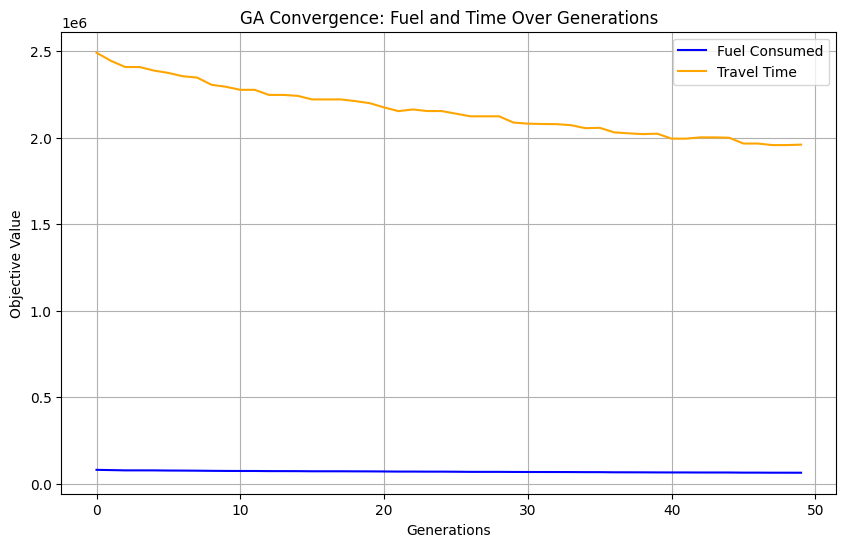

In [26]:
# Plot the convergence graph
def plot_convergence(fitness_values):
    fitness_values = np.array(fitness_values)
    
    plt.figure(figsize=(10, 6))
    plt.plot(fitness_values[:, 0], label="Fuel Consumed", color='blue')
    plt.plot(fitness_values[:, 1], label="Travel Time", color='orange')
    
    plt.title("GA Convergence: Fuel and Time Over Generations")
    plt.xlabel("Generations")
    plt.ylabel("Objective Value")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_convergence(fitness_values)

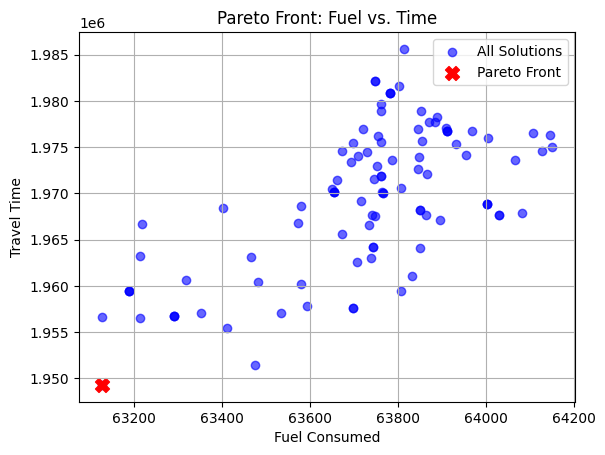

In [27]:


# Function to check if one individual dominates another
def dominates(ind1, ind2):
    # Checks if ind1 dominates ind2 (minimizing both objectives)
    return (ind1[0] <= ind2[0] and ind1[1] <= ind2[1]) and (ind1[0] < ind2[0] or ind1[1] < ind2[1])

# Pareto front analysis (optional, can be visualized)
def plot_pareto_front(populations):
    all_fuels = []
    all_times = []
    
    # Collect all solutions (fuel, time)
    for pop in populations:
        for ind in pop:
            fuel, time = evaluate(ind)
            all_fuels.append(fuel)
            all_times.append(time)
    
    # Convert to a list of (fuel, time) pairs
    solutions = list(zip(all_fuels, all_times))
    
    # Find the non-dominated solutions (Pareto front)
    pareto_front = []
    for i, sol1 in enumerate(solutions):
        is_dominated = False
        for j, sol2 in enumerate(solutions):
            if i != j and dominates(sol2, sol1):
                is_dominated = True
                break
        if not is_dominated:
            pareto_front.append(i)
    
    # Plot all solutions
    plt.scatter(all_fuels, all_times, color='blue', label='All Solutions', alpha=0.6)
    
    # Highlight the Pareto front
    pareto_fuels = [solutions[i][0] for i in pareto_front]
    pareto_times = [solutions[i][1] for i in pareto_front]
    plt.scatter(pareto_fuels, pareto_times, color='red', label='Pareto Front', marker='X', s=100)
    
    plt.xlabel("Fuel Consumed")
    plt.ylabel("Travel Time")
    plt.title("Pareto Front: Fuel vs. Time")
    plt.grid(True)
    plt.legend()
    plt.show()

# Plot the Pareto front
plot_pareto_front(populations)


### Data Modeling with Standard Scaler

In [ ]:
from sklearn.preprocessing import StandardScaler

# Apply StandardScaler to scale Total_Fuel_Consumed and Total_Travel_Time
scaler = StandardScaler()
aggregated_data[['Scaled_Fuel', 'Scaled_Time']] = scaler.fit_transform(
    aggregated_data[['Total_Fuel_Consumed', 'Total_Travel_Time']]
)

# Fitness function to evaluate scaled travel time and fuel consumption
def evaluate(individual):
    total_fuel = sum(aggregated_data[aggregated_data["Route_ID"] == route]["Scaled_Fuel"].values[0] for route in individual)
    total_time = sum(aggregated_data[aggregated_data["Route_ID"] == route]["Scaled_Time"].values[0] for route in individual)
    return total_fuel, total_time  # Return both objectives

toolbox.register("evaluate", evaluate)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.05)
toolbox.register("select", tools.selNSGA2)  # Use NSGA-II for multi-objective optimization

# Modified genetic algorithm to track convergence, Pareto front, and other metrics
def run_ga_with_params(pop_size, cxpb, mutpb, n_generations):
    pop = toolbox.population(n=pop_size)
    hof = tools.HallOfFame(1)
    
    # Track metrics
    fitness_values = []  # For convergence plot
    populations = []  # For Pareto front analysis
    diversity_metrics = []  # For diversity analysis
    best_solutions = []  # For hyperparameter stability
    start_time = time.time()  # For scalability analysis

    for gen in range(n_generations):
        # Track the best fitness values for convergence plot
        best_individual = tools.selBest(pop, 1)[0]
        best_fuel, best_time = evaluate(best_individual)
        fitness_values.append((best_fuel, best_time))

        # Track population for Pareto front analysis
        populations.append(pop)

        # Track diversity - here using Euclidean distance between individuals
        diversity = np.mean([np.linalg.norm(np.array(ind1) - np.array(ind2)) for ind1 in pop for ind2 in pop if ind1 != ind2])
        diversity_metrics.append(diversity)

        # Track the best solution for stability analysis
        best_solutions.append((best_fuel, best_time))

        # Run the genetic algorithm for this generation
        algorithms.eaMuPlusLambda(pop, toolbox, mu=pop_size, lambda_=pop_size,
                                  cxpb=cxpb, mutpb=mutpb, ngen=1,  # Run for one generation
                                  stats=None, halloffame=hof, verbose=False)
    
    # Record total runtime for scalability analysis
    end_time = time.time()
    execution_time = end_time - start_time

    # Return all relevant values
    best_individual = hof[0]
    best_fuel, best_time = evaluate(best_individual)
    
    return best_fuel, best_time, pop, fitness_values, populations, diversity_metrics, best_solutions, execution_time

# Now you can run the GA with StandardScaler applied to the data
param_grid = {
    'pop_size': [100],        # Fixed population size
    'cxpb': [0.7],            # Fixed crossover probability
    'mutpb': [0.1],           # Fixed mutation probability
    'n_generations': [50]     # Fixed number of generations
}

param_combinations = list(itertools.product(*param_grid.values()))

best_results = []

for params in param_combinations:
    pop_size, cxpb, mutpb, n_generations = params
    print(f"Running GA with parameters: pop_size={pop_size}, cxpb={cxpb}, mutpb={mutpb}, n_generations={n_generations}")
    
    best_fuel, best_time, _, fitness_values, _, _, _, execution_time = run_ga_with_params(pop_size, cxpb, mutpb, n_generations)
    best_results.append((params, best_fuel, best_time))

# Find the best hyperparameters based on scaled fuel and time

# Inverse transform the best scaled fuel and time
original_fuel = scaler.inverse_transform([[best_fuel, best_time]])[0][0]  # Inverse transform for fuel
original_time = scaler.inverse_transform([[best_fuel, best_time]])[0][1]  # Inverse transform for time

print(f"Optimized Fuel (real-world): {original_fuel}")
print(f"Optimized Time (real-world): {original_time}")

Running GA with parameters: pop_size=100, cxpb=0.7, mutpb=0.1, n_generations=50
Best parameters: (100, 0.7, 0.1, 50)
Optimized Scaled Fuel: -106.03528442891995
Optimized Scaled Time: -105.9446075758796


### Convergence Plot

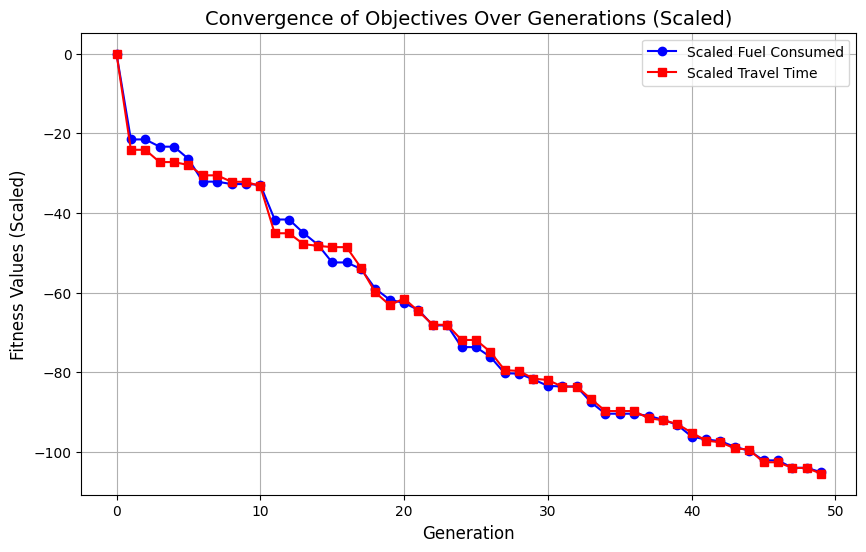

In [35]:
import matplotlib.pyplot as plt

# Function to plot the convergence of the best fitness values over generations
def plot_convergence(fitness_values):
    # Separate the fitness values into components (scaled fuel and scaled time)
    scaled_fuel_values = [fv[0] for fv in fitness_values]
    scaled_time_values = [fv[1] for fv in fitness_values]

    # Generate x-axis as generations (0 to number of generations)
    generations = range(len(fitness_values))

    # Create the plot
    plt.figure(figsize=(10, 6))
    plt.plot(generations, scaled_fuel_values, label="Scaled Fuel Consumed", marker='o', color='blue')
    plt.plot(generations, scaled_time_values, label="Scaled Travel Time", marker='s', color='red')

    # Customize the plot
    plt.title("Convergence of Objectives Over Generations (Scaled)", fontsize=14)
    plt.xlabel("Generation", fontsize=12)
    plt.ylabel("Fitness Values (Scaled)", fontsize=12)
    plt.legend(loc='best')
    plt.grid(True)

    # Display the plot
    plt.show()

# Assuming fitness_values is available from the GA (list of tuples like [(fuel, time), (fuel, time), ...])
# Example: fitness_values = [(63127, 1949297), (62500, 1900000), ...]
# You would call the function with fitness values collected during the GA run
plot_convergence(fitness_values)


### Pareto Front

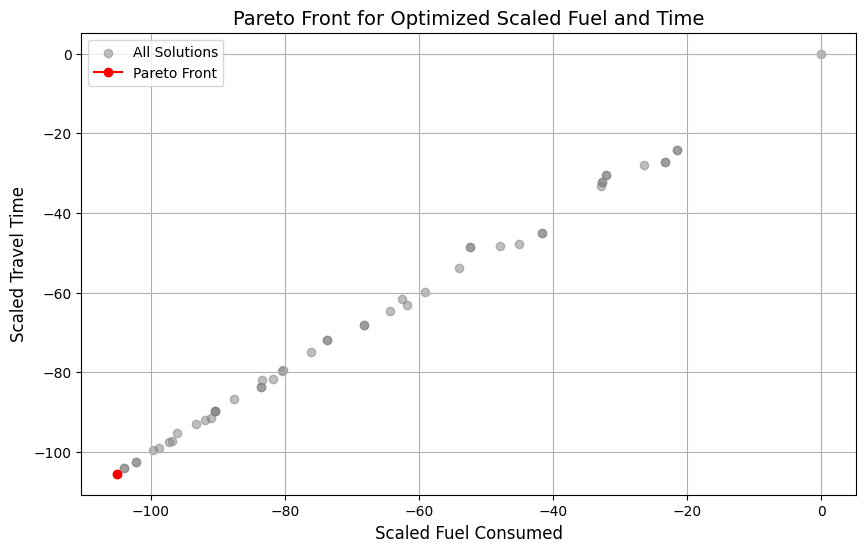

In [37]:
import matplotlib.pyplot as plt
import numpy as np

# Function to plot the Pareto front
def plot_pareto_front(fitness_values):
    # Extract the scaled fuel and scaled time values from the fitness values
    scaled_fuel_values = [fv[0] for fv in fitness_values]
    scaled_time_values = [fv[1] for fv in fitness_values]
    
    # Combine the two objectives into a list of tuples (scaled_fuel, scaled_time)
    objectives = list(zip(scaled_fuel_values, scaled_time_values))

    # Sort objectives by scaled fuel and scaled time to identify the Pareto front
    objectives_sorted = sorted(objectives, key=lambda x: (x[0], x[1]))

    # Identify the Pareto front: Start with the first point
    pareto_front = [objectives_sorted[0]]
    for i in range(1, len(objectives_sorted)):
        if objectives_sorted[i][0] < pareto_front[-1][0] or objectives_sorted[i][1] < pareto_front[-1][1]:
            pareto_front.append(objectives_sorted[i])
    
    # Convert Pareto front to separate lists for plotting
    pareto_fuel, pareto_time = zip(*pareto_front)
    
    # Plot the Pareto front and all points
    plt.figure(figsize=(10, 6))
    plt.scatter(scaled_fuel_values, scaled_time_values, color='gray', label='All Solutions', alpha=0.5)
    plt.plot(pareto_fuel, pareto_time, color='red', label='Pareto Front', marker='o', linestyle='-', markersize=6)

    # Customize the plot
    plt.title("Pareto Front for Optimized Scaled Fuel and Time", fontsize=14)
    plt.xlabel("Scaled Fuel Consumed", fontsize=12)
    plt.ylabel("Scaled Travel Time", fontsize=12)
    plt.legend(loc='best')
    plt.grid(True)

    # Show the plot
    plt.show()

# Assuming fitness_values is available from the GA (list of tuples like [(fuel, time), (fuel, time), ...])
# Example: fitness_values = [(63127, 1949297), (62500, 1900000), ...]
# You would call the function with fitness values collected during the GA run
plot_pareto_front(fitness_values)


### Polynomial Feature Transformation

In [42]:
import pandas as pd
import numpy as np
import itertools
import time
from deap import base, creator, tools, algorithms
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt

# Assuming 'aggregated_data' DataFrame is available
# Apply PolynomialFeatures to create interaction terms for fuel and time
poly = PolynomialFeatures(degree=2, include_bias=False)
polynomial_features = poly.fit_transform(aggregated_data[['Total_Fuel_Consumed', 'Total_Travel_Time']])

# Create a new dataframe with the polynomial features
poly_feature_names = poly.get_feature_names_out(['Total_Fuel_Consumed', 'Total_Travel_Time'])
poly_df = pd.DataFrame(polynomial_features, columns=poly_feature_names)

# Add the polynomial features back to the aggregated_data dataframe
for col in poly_feature_names:
    aggregated_data[col] = poly_df[col]

# Create a toolbox for DEAP
creator.create("FitnessMulti", base.Fitness, weights=(-1.0, -1.0, -1.0))  # Minimize fuel, time, and interaction term
creator.create("Individual", list, fitness=creator.FitnessMulti)

toolbox = base.Toolbox()
toolbox.register("attr_route", lambda: np.random.choice(aggregated_data["Route_ID"].values))
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_route, n=10)  # Assuming 10 routes
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Fitness function to evaluate the polynomial features
def evaluate(individual):
    total_fuel = 0
    total_time = 0
    interaction_fuel_time = 0
    
    for route in individual:
        # Check if the route exists in the dataframe
        route_data = aggregated_data[aggregated_data["Route_ID"] == route]
        
        if not route_data.empty:  # Only proceed if the route exists
            total_fuel += route_data["Total_Fuel_Consumed"].values[0]
            total_time += route_data["Total_Travel_Time"].values[0]
            interaction_fuel_time += route_data["Total_Fuel_Consumed Total_Travel_Time"].values[0]
        else:
            print(f"Warning: Route ID {route} not found in the data.")
    
    # Fitness now incorporates the polynomial interaction term
    return total_fuel, total_time, interaction_fuel_time

toolbox.register("evaluate", evaluate)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.05)
toolbox.register("select", tools.selNSGA2)  # Use NSGA-II for multi-objective optimization

# Modified genetic algorithm with polynomial features
def run_ga_with_params(pop_size, cxpb, mutpb, n_generations):
    pop = toolbox.population(n=pop_size)
    hof = tools.HallOfFame(1)
    
    # Track metrics
    fitness_values = []  # For convergence plot
    populations = []  # For Pareto front analysis
    diversity_metrics = []  # For diversity analysis
    best_solutions = []  # For hyperparameter stability
    start_time = time.time()  # For scalability analysis

    for gen in range(n_generations):
        # Track the best fitness values for convergence plot
        best_individual = tools.selBest(pop, 1)[0]
        best_fuel, best_time, interaction = evaluate(best_individual)
        fitness_values.append((best_fuel, best_time, interaction))

        # Track population for Pareto front analysis
        populations.append(pop)

        # Track diversity - here using Euclidean distance between individuals
        diversity = np.mean([np.linalg.norm(np.array(ind1) - np.array(ind2)) for ind1 in pop for ind2 in pop if ind1 != ind2])
        diversity_metrics.append(diversity)

        # Track the best solution for stability analysis
        best_solutions.append((best_fuel, best_time, interaction))

        # Run the genetic algorithm for this generation
        algorithms.eaMuPlusLambda(pop, toolbox, mu=pop_size, lambda_=pop_size,
                                  cxpb=cxpb, mutpb=mutpb, ngen=1,  # Run for one generation
                                  stats=None, halloffame=hof, verbose=False)
    
    # Record total runtime for scalability analysis
    end_time = time.time()
    execution_time = end_time - start_time

    # Return all relevant values
    best_individual = hof[0]
    best_fuel, best_time, interaction = evaluate(best_individual)
    
    return best_fuel, best_time, interaction, pop, fitness_values, populations, diversity_metrics, best_solutions, execution_time

# Now run the genetic algorithm
param_grid = {
    'pop_size': [100],        # Fixed population size
    'cxpb': [0.7],            # Fixed crossover probability
    'mutpb': [0.1],           # Fixed mutation probability
    'n_generations': [50]     # Fixed number of generations
}

param_combinations = list(itertools.product(*param_grid.values()))

best_results = []

for params in param_combinations:
    pop_size, cxpb, mutpb, n_generations = params
    print(f"Running GA with parameters: pop_size={pop_size}, cxpb={cxpb}, mutpb={mutpb}, n_generations={n_generations}")
    
    best_fuel, best_time, interaction, _, fitness_values, _, _, _, execution_time = run_ga_with_params(pop_size, cxpb, mutpb, n_generations)
    best_results.append((params, best_fuel, best_time, interaction))

# Find the best hyperparameters based on fuel, time, and interaction term
best_params = min(best_results, key=lambda x: (x[1], x[2], x[3]))  # Minimize all three objectives
print(f"Best parameters: {best_params[0]}")
print(f"Optimized Fuel: {best_params[1]}")
print(f"Optimized Time: {best_params[2]}")
print(f"Optimized Interaction Term: {best_params[3]}")


c:\Users\HomePC\AppData\Local\Programs\Python\Python311\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


Running GA with parameters: pop_size=100, cxpb=0.7, mutpb=0.1, n_generations=50


c:\Users\HomePC\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\HomePC\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Best parameters: (100, 0.7, 0.1, 50)
Optimized Fuel: 4933.072000000001
Optimized Time: 145958.99999999997
Optimized Interaction Term: 72002625.6048


### Convergence Plot

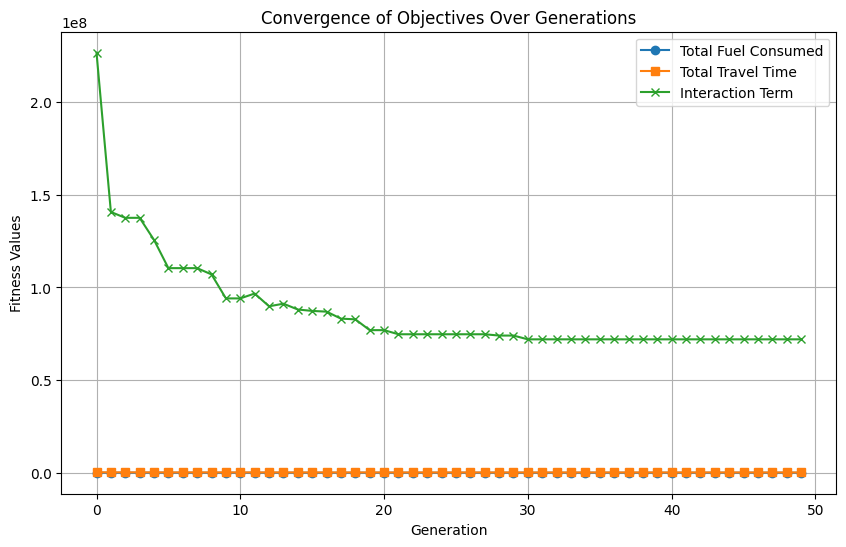

In [43]:
import matplotlib.pyplot as plt

def plot_convergence(fitness_values):
    # Separate the fitness values into components
    fuel_values = [fv[0] for fv in fitness_values]
    time_values = [fv[1] for fv in fitness_values]
    interaction_values = [fv[2] for fv in fitness_values]

    # Plot the convergence for each objective
    generations = range(len(fitness_values))

    plt.figure(figsize=(10, 6))
    plt.plot(generations, fuel_values, label="Total Fuel Consumed", marker='o')
    plt.plot(generations, time_values, label="Total Travel Time", marker='s')
    plt.plot(generations, interaction_values, label="Interaction Term", marker='x')

    plt.title("Convergence of Objectives Over Generations")
    plt.xlabel("Generation")
    plt.ylabel("Fitness Values")
    plt.legend()
    plt.grid()
    plt.show()

# Call the function using the `fitness_values` from the genetic algorithm
plot_convergence(fitness_values)


### Pareto Front 

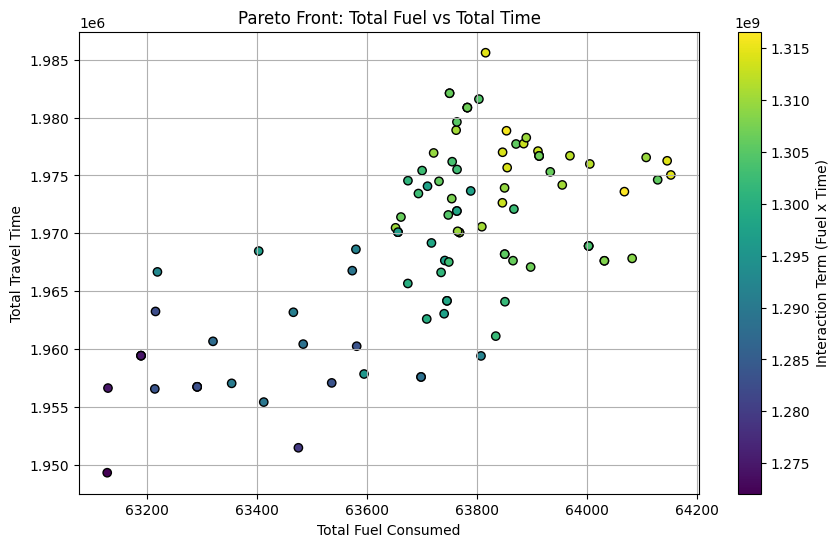

In [44]:
def plot_pareto_front(population, aggregated_data):
    # Extract fuel and time for all individuals in the population
    pareto_fuel = []
    pareto_time = []
    pareto_interaction = []

    for ind in population:
        fuel, time, interaction = evaluate(ind)
        pareto_fuel.append(fuel)
        pareto_time.append(time)
        pareto_interaction.append(interaction)

    # Plot the Pareto front for fuel vs. time
    plt.figure(figsize=(10, 6))
    plt.scatter(pareto_fuel, pareto_time, c=pareto_interaction, cmap='viridis', edgecolor='k')
    plt.colorbar(label="Interaction Term (Fuel x Time)")
    plt.title("Pareto Front: Total Fuel vs Total Time")
    plt.xlabel("Total Fuel Consumed")
    plt.ylabel("Total Travel Time")
    plt.grid()
    plt.show()

# Call the function using the final population
plot_pareto_front(pop, aggregated_data)
